In [1]:
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# A Short Introduction to Time Series Forecasting

**Forecasting** is where we try to predict an variables future value. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. In this guide you'll learn to:

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

Written with the help of [this kaggle tutorial](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series) and these [videos](https://www.youtube.com/watch?v=9QtL7m3YS9I), and some figures taken from [this blog](https://medium.com/analytics-vidhya/time-series-forecasting-c73dec0b7533).

> “Forecasting is the art of saying what will happen, and then explaining why it didn’t!”
>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')



In [3]:
data_path = Path('price/INTC.csv') # Update your path here

In [4]:
df = pd.read_csv(data_path, header=0)

### A quick look at the dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000
1,2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800
2,2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600
3,2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100
4,2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600


# 1.0 EDA


In [7]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

## 1.1 Time Series Plot

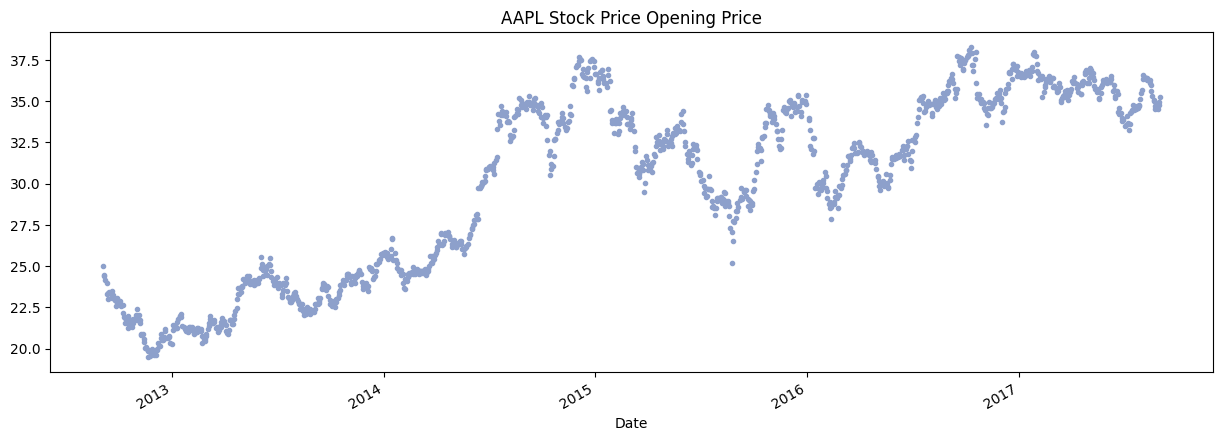

In [8]:
df["Open"].plot(title='AAPL Stock Price Opening Price',
        style='.',
        figsize=(15,5),
        use_index=True,
        color=color_pal[2])
plt.show()

## 1.2 distribution

<Axes: ylabel='Frequency'>

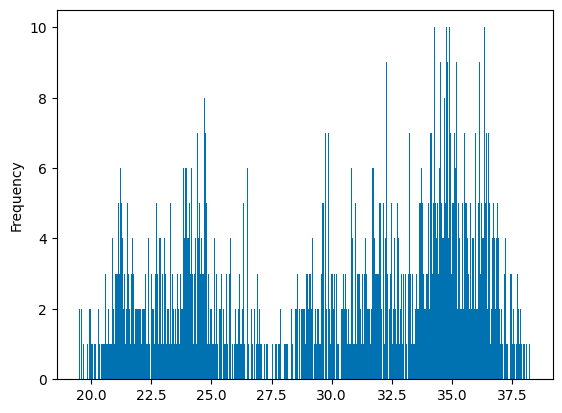

In [9]:
df['Open'].plot(kind='hist', bins=500) # Opening prices are not normal

In [10]:
df['Pct Change'] = df['Close'].pct_change() * 100

In [11]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume,Pct Change
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1257.000000
mean,29.985676,30.247194,29.738593,30.005238,27.957586,3.103016e+07,0.038205
std,5.370144,5.400717,5.331414,5.374578,6.033379,1.618260e+07,1.368211
min,19.520000,19.549999,19.230000,19.360001,16.589478,5.893800e+06,-9.102021
25%,24.542500,24.742500,24.400000,24.542500,21.852218,2.092898e+07,-0.684556
50%,31.430000,31.760000,31.200001,31.500000,29.652850,2.708505e+07,0.062076
75%,34.750000,34.959999,34.497501,34.750000,33.353392,3.539780e+07,0.751880
max,38.250000,38.450001,37.900002,38.099998,37.153412,1.437604e+08,9.271533


## 1.3 Train Test Split

- Important to prevent our model from horribly overfitting

We set the train set before 2016, while 2016 to 2017 data is the test set.

In [12]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

In [13]:
train

,Open,High,Low,Close,Adj Close,Volume,Pct Change
Date,,,,,,,
2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000,NaN
2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800,-0.122854
2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600,2.911033
2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100,-3.625494
2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600,-3.844568
...,...,...,...,...,...,...,...
2015-12-24,35.070000,35.259998,34.959999,34.980000,33.125854,5893800,-0.057143
2015-12-28,34.950001,35.000000,34.570000,34.930000,33.078503,9449400,-0.142939
2015-12-29,35.009998,35.590000,35.009998,35.439999,33.561470,14188600,1.460060


### *Sentiment data are in range 2014-01-01 to 2015-12-31.*

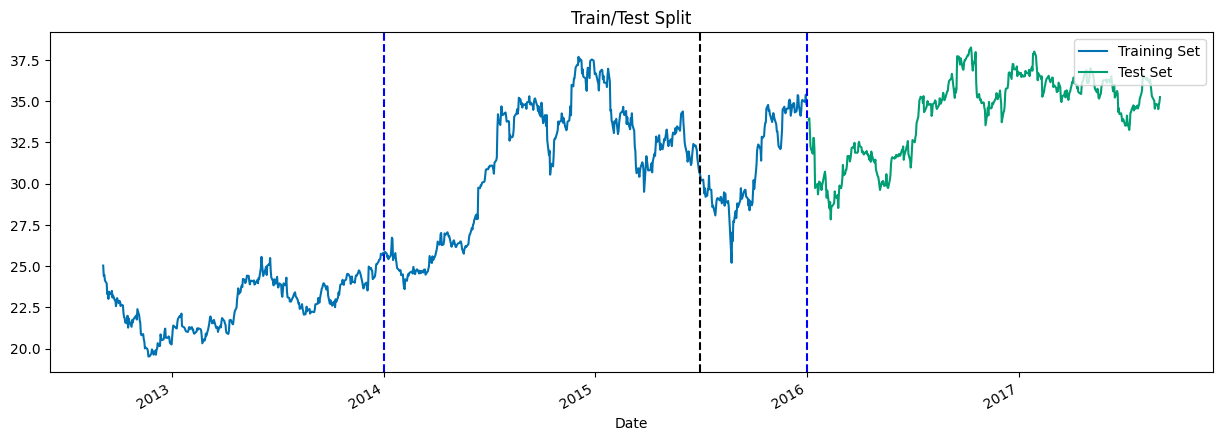

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

train['Open'].plot(ax=ax, label='Train', title='Train/Test Split')
test['Open'].plot(ax=ax, label='Test')
ax.axvline('2015-07-01', color='black', ls='--')
ax.axvline('2016-01-01', color='blue', ls='--')
ax.axvline('2014-01-01', color='blue', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [15]:
openp = df[['Open']].copy()  
openp.reset_index(inplace=True)  
openp.columns = ['Date', 'Open'] 
openp


,Date,Open
0,2012-09-04,25.030001
1,2012-09-05,24.400000
2,2012-09-06,24.469999
3,2012-09-07,24.129999
4,2012-09-10,23.950001
...,...,...
1253,2017-08-28,34.779999
1254,2017-08-29,34.509998
1255,2017-08-30,34.750000
1256,2017-08-31,34.939999


In [16]:
df.reset_index(inplace=True) 
price_df = pd.DataFrame({
    'Date': df['Date'],
    'Price': df['Open']
})
price_df['Date'] = pd.to_datetime(price_df['Date'])


In [17]:
price_df

,Date,Price
0,2012-09-04,25.030001
1,2012-09-05,24.400000
2,2012-09-06,24.469999
3,2012-09-07,24.129999
4,2012-09-10,23.950001
...,...,...
1253,2017-08-28,34.779999
1254,2017-08-29,34.509998
1255,2017-08-30,34.750000
1256,2017-08-31,34.939999


# 2.0 Model Processing

Considering sentiment data, pos -- 1, neu --0, neg -- -1.

## 2.1 XGBOOST

In [18]:
sentiment_df = pd.read_csv('./sentiment_data.csv')
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
merged_data = pd.merge(price_df, sentiment_df, left_on='Date', right_on='Date', how='inner')

merged_data['Sentiment'] = merged_data['Sentiment'].replace({'POS': 1, 'NEG': -1, 'NEU': 0})


In [19]:
merged_data

,Date,Price,Sentiment
0,2014-01-02,25.780001,0
1,2014-01-03,25.860001,1
2,2014-01-06,25.770000,0
3,2014-01-07,25.540001,1
4,2014-01-08,25.639999,1
...,...,...,...
408,2015-12-24,35.070000,1
409,2015-12-28,34.950001,0
410,2015-12-29,35.009998,1
411,2015-12-30,35.380001,1


In [20]:
merged_data.set_index('Date', inplace=True)


Best Hyperparameters: {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Mean Squared Error: 0.9086


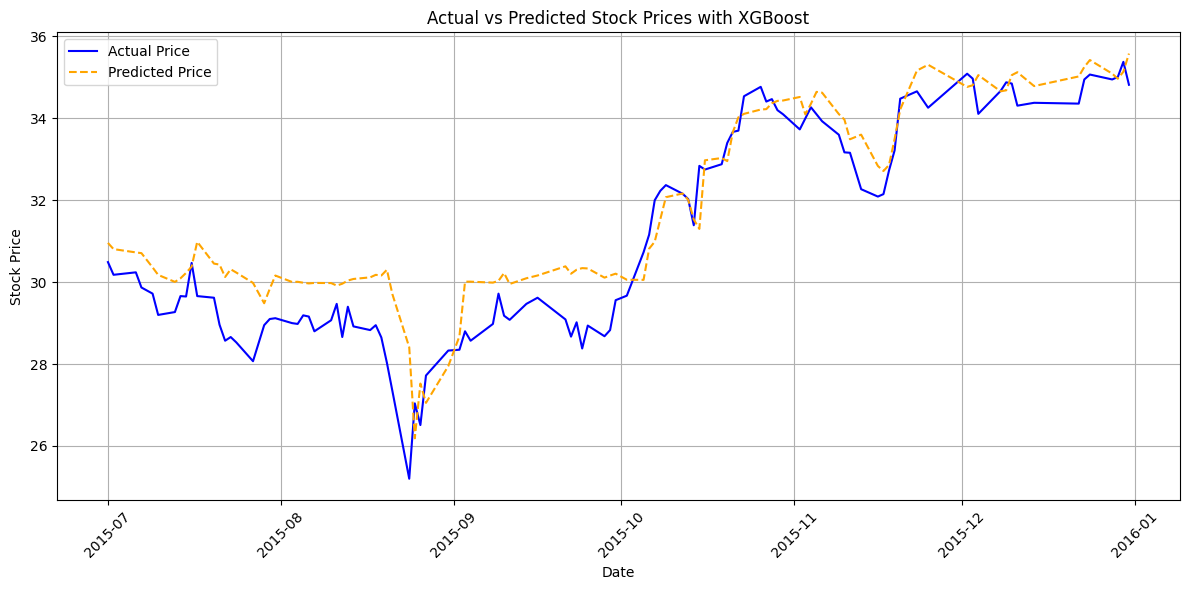

In [21]:
from sklearn.metrics import mean_squared_error
# Extract date features from the index
merged_data['Year'] = merged_data.index.year
merged_data['Month'] = merged_data.index.month
merged_data['Day'] = merged_data.index.day



# Create lag features
merged_data['Price_Lag_1'] = merged_data['Price'].shift(1)
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment'].shift(1)

# Adding more lag features
merged_data['Price_Lag_2'] = merged_data['Price'].shift(2)
merged_data['Sentiment_Lag_2'] = merged_data['Sentiment'].shift(2)

# Drop missing values
merged_data.dropna(inplace=True)

# Define features and target variable
X = merged_data[['Price_Lag_1', 'Price_Lag_2', 'Sentiment_Lag_1', 'Sentiment_Lag_2', 'Year', 'Month', 'Day']]
y = merged_data['Price']


# Split the data into training and testing sets
X_train = X[merged_data.index < '2015-07-01']
y_train = y[merged_data.index < '2015-07-01']

X_test = X[merged_data.index >= '2015-07-01']
y_test = y[merged_data.index >= '2015-07-01']

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
        'alpha': [0, 0.1, 0.5],    
    'lambda': [1, 1.5, 2]      
}

# Create XGBoost model
xgb = XGBRegressor(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Retrain the model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict stock prices for the test set
y_pred = best_model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Create a DataFrame to save actual and predicted prices for the test set
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
}, index=X_test.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual Price'], label='Actual Price', color='blue')
plt.plot(results.index, results['Predicted Price'], label='Predicted Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices with XGBoost')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


accuracy_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error', 
               'Root Mean Squared Error', 
               'Mean Absolute Error', 
               'R² Score', 
               'Mean Absolute Percentage Error'],
    'Value': [mse, rmse, mae, r2, mape]
})


accuracy_matrix


,Metric,Value
0,Mean Squared Error,0.908551
1,Root Mean Squared Error,0.953179
2,Mean Absolute Error,0.765058
3,R² Score,0.863631
4,Mean Absolute Percentage Error,2.575070


## Limitation : 

1. Overfit, though try multiple models and regulizations, this is the best one.

2. Sentiment data may not be important here, maybe due to the low data volumn, short time period. 

3. Stock price is affected by many other indicated but is not accounted in the model. 

4. According to behavioral finance, few investors can beat market. Only few of them are rational. But there's still a group of people can beat the market and the index, which may neturalize the influence of their emotion and influence from social media. It may be the broker and dealer take the lion's share.

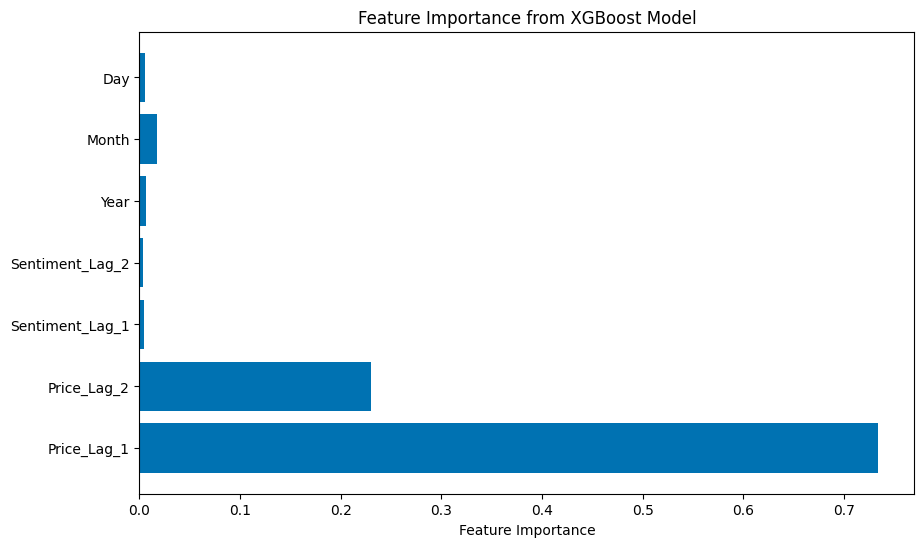

In [23]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.yticks(range(len(best_model.feature_importances_)), X.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')
plt.show()

#### RANDOM FOREST

Mean Squared Error: 0.5096


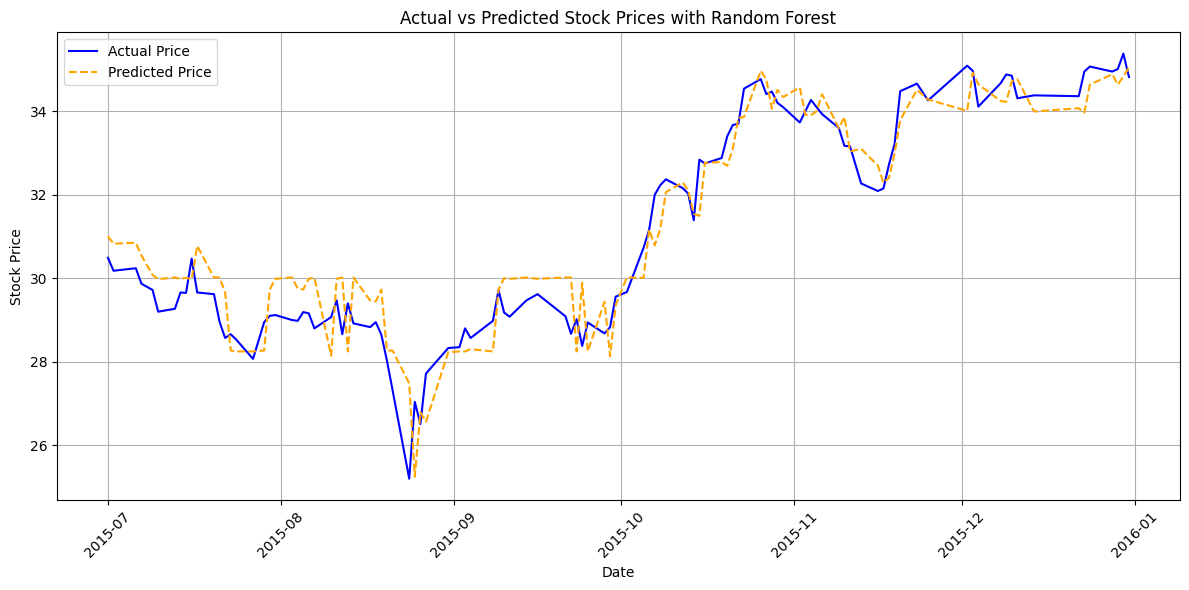

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

merged_data['Price_Lag_1'] = merged_data['Price'].shift(1)
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment'].shift(1)

merged_data.dropna(inplace=True)

X = merged_data[['Price_Lag_1', 'Sentiment_Lag_1']]
y = merged_data['Price']

X_train = X[merged_data.index < '2015-07-01']
y_train = y[merged_data.index < '2015-07-01']

X_test = X[merged_data.index >= '2015-07-01']
y_test = y[merged_data.index >= '2015-07-01']

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
}, index=X_test.index)

plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual Price'], label='Actual Price', color='blue')
plt.plot(results.index, results['Predicted Price'], label='Predicted Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices with Random Forest')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

accuracy_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error', 
               'Root Mean Squared Error', 
               'Mean Absolute Error', 
               'R² Score', 
               'Mean Absolute Percentage Error'],
    'Value': [mse, rmse, mae, r2, mape]
})

print(accuracy_matrix)


                           Metric     Value
0              Mean Squared Error  0.509649
1         Root Mean Squared Error  0.713897
2             Mean Absolute Error  0.580250
3                        R² Score  0.923504
4  Mean Absolute Percentage Error  1.926075
